In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymc as pm
# import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

In [4]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [6]:
data = pd.read_csv('Full_Descriptors.csv')
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy versio

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.8508468311671086
Train AUC ROC Score for GS:  0.9637183113484363
Test AUC ROC Score for GS:  0.8334048027444254


Text(0.5, 1.0, 'LUMO')

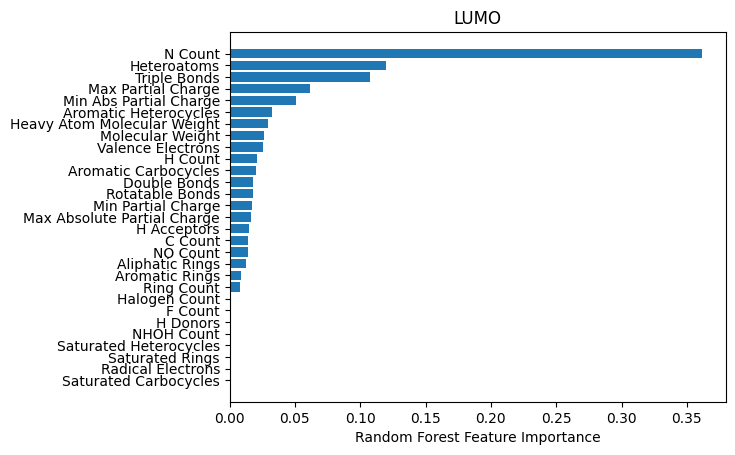

In [8]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

In [9]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

N Count 0.670 +/- 0.071
Triple Bonds0.170 +/- 0.019
Heteroatoms0.134 +/- 0.018
Min Abs Partial Charge0.067 +/- 0.007
Max Partial Charge0.058 +/- 0.005
H Count 0.027 +/- 0.003
Aromatic Carbocycles0.026 +/- 0.004
Aromatic Heterocycles0.018 +/- 0.003
Double Bonds0.017 +/- 0.002
Aliphatic Rings0.015 +/- 0.002
Heavy Atom Molecular Weight0.015 +/- 0.001
Min Partial Charge0.013 +/- 0.001
Valence Electrons0.013 +/- 0.001
Max Absolute Partial Charge0.013 +/- 0.001
Rotatable Bonds0.012 +/- 0.002
C Count 0.011 +/- 0.001
H Acceptors0.010 +/- 0.001
Molecular Weight0.010 +/- 0.001
NO Count0.009 +/- 0.001
Aromatic Rings0.005 +/- 0.001
Ring Count0.005 +/- 0.001
Halogen Count0.001 +/- 0.000
F Count 0.001 +/- 0.000
H Donors0.000 +/- 0.000
Saturated Rings0.000 +/- 0.000


In [13]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

N Count 0.652 +/- 0.166
Triple Bonds0.187 +/- 0.070
Double Bonds0.047 +/- 0.013
Max Absolute Partial Charge0.046 +/- 0.007
Min Partial Charge0.042 +/- 0.009
H Count 0.029 +/- 0.014
H Donors0.001 +/- 0.000


In [14]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [15]:
from sklearn.metrics import mean_squared_error

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.40941349047534237
MSE:  5.744839875506793e-05
RMSE:  0.007579472195019118


In [16]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 104.13 %.


In [17]:
naive_roc_auc_score(y_test, prediction)

0.8334048027444254

In [18]:
data = pd.read_csv('Full_Descriptors.csv')
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7807120719053036
Train AUC ROC Score for GS:  0.9455990548305676
Test AUC ROC Score for GS:  0.8290948275862069


Text(0.5, 1.0, 'HOMO')

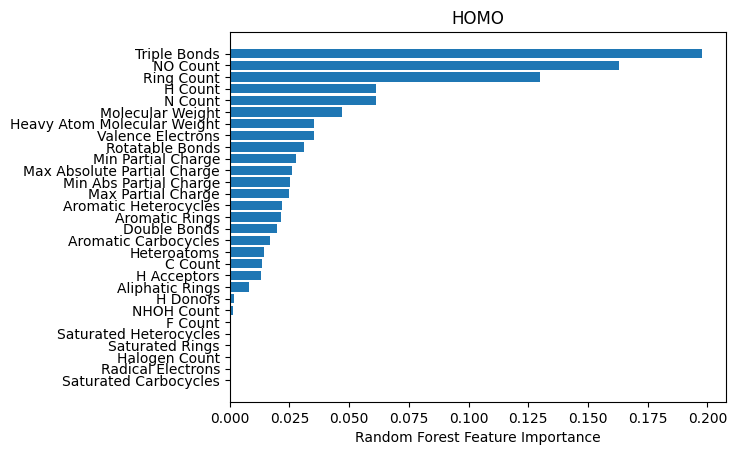

In [20]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title('HOMO')

In [21]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Triple Bonds0.247 +/- 0.027
NO Count0.169 +/- 0.016
Ring Count0.165 +/- 0.017
Molecular Weight0.062 +/- 0.005
H Count 0.057 +/- 0.005
N Count 0.052 +/- 0.005
Rotatable Bonds0.034 +/- 0.003
Heavy Atom Molecular Weight0.031 +/- 0.003
Valence Electrons0.028 +/- 0.002
Min Partial Charge0.027 +/- 0.002
Max Partial Charge0.026 +/- 0.003
Aromatic Carbocycles0.023 +/- 0.002
Double Bonds0.022 +/- 0.002
Min Abs Partial Charge0.022 +/- 0.001
Max Absolute Partial Charge0.022 +/- 0.002
Aromatic Heterocycles0.020 +/- 0.002
Aromatic Rings0.015 +/- 0.002
H Acceptors0.010 +/- 0.001
C Count 0.010 +/- 0.001
Heteroatoms0.008 +/- 0.001
Aliphatic Rings0.007 +/- 0.001
NHOH Count0.001 +/- 0.000
H Donors0.001 +/- 0.000
F Count 0.000 +/- 0.000
Halogen Count0.000 +/- 0.000
Saturated Heterocycles0.000 +/- 0.000


In [22]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

NO Count0.303 +/- 0.077
Triple Bonds0.159 +/- 0.037
Ring Count0.123 +/- 0.037
H Count 0.072 +/- 0.013
Molecular Weight0.046 +/- 0.016
Rotatable Bonds0.038 +/- 0.007
Min Partial Charge0.024 +/- 0.006
Max Absolute Partial Charge0.020 +/- 0.008
Heavy Atom Molecular Weight0.017 +/- 0.005
Aromatic Rings0.009 +/- 0.002


In [23]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [24]:
from sklearn.metrics import mean_squared_error

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.720851721575162
MSE:  2.494018960616685e-05
RMSE:  0.004994015379047891
